# Predict Future Sales 日本語  

## ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product
from sklearn.preprocessing import LabelEncoder
import datetime
import re

import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

import time
import gc
import pickle

# 描画サイズ
plt.rcParams["figure.figsize"] = (20 ,10)

In [2]:
cd competitive-data-science-predict-future-sales

C:\Users\tsube\OneDrive\デスクトップ\playground\最終課題\competitive-data-science-predict-future-sales


## データの読み込み

In [3]:
#データの読み込み
cats = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
train = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
display(train)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## 外れ値除外

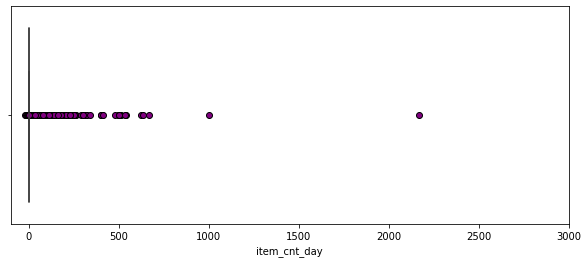

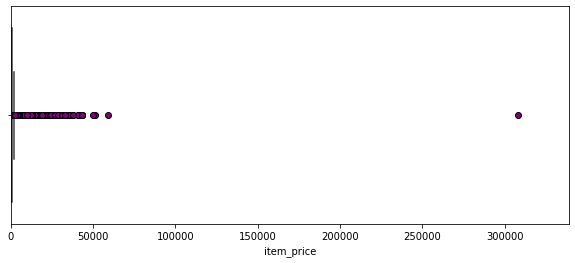

outlier fix run time: 1.137838363647461


In [4]:
# 外れ値の処理と可視化

ts = time.time()

plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)
plt.show()

# exclude outliers
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]
train = train[train.item_price > 0].reset_index(drop = True)
# 返品処理されたもの(値がマイナス)は、売上0として扱う
# train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

# print run time
print(f"outlier fix run time: {time.time()-ts}")

## データの整理  

### shops df

In [5]:
#shops dfの前処理
ts = time.time()

# shop_nameの重複を修正
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# city_nameをshop_category_nameから作成
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city_name"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["shop_category_name"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city_name == "!Якутск", "city_name"] = "Якутск"



# label-encording
shops["shop_category_id"] = LabelEncoder().fit_transform(shops.shop_category_name)
shops["city_id"] = LabelEncoder().fit_transform( shops.city_name )
display(shops.head())
shops = shops[["shop_id", "shop_category_id", "city_id"]]
display(shops.head())

# print run time
print(f"run time: {time.time()-ts}")

,shop_name,shop_id,city_name,shop_category_name,shop_category_id,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,"Орджоникидзе,",4,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ,8,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ,8,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК,6,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ,8,2


,shop_id,shop_category_id,city_id
0,0,4,29
1,1,8,29
2,2,8,0
3,3,6,1
4,4,8,2


run time: 0.060999155044555664


### cats-df

In [6]:
# cats-dfの前処理
ts = time.time()

# type_nameをcats-dfへ追加
cats["type_name"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_name == "Игровые")| (cats.type_name == "Аксессуары"), "type_name" ] = "Игры"



#label-encording
cats["type_id"] = LabelEncoder().fit_transform(cats.type_name)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_id"] = LabelEncoder().fit_transform(cats.subtype)
display(cats.head())
cats = cats[["item_category_id", "subtype_id", "type_id"]]
display(cats.head())

# print run time
print(f"run time: {time.time()-ts}")

,item_category_name,item_category_id,type_name,type_id,split,subtype,subtype_id
0,PC - Гарнитуры/Наушники,0,PC,0,"[PC , Гарнитуры/Наушники]",Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,Игры,3,"[Аксессуары , PS2]",PS2,9
2,Аксессуары - PS3,2,Игры,3,"[Аксессуары , PS3]",PS3,10
3,Аксессуары - PS4,3,Игры,3,"[Аксессуары , PS4]",PS4,11
4,Аксессуары - PSP,4,Игры,3,"[Аксессуары , PSP]",PSP,13


,item_category_id,subtype_id,type_id
0,0,29,0
1,1,9,3
2,2,10,3
3,3,11,3
4,4,13,3


run time: 0.01395726203918457


### items-df

## データをまとめる
### 組み合わせ作成  
> 組み合わせパターンを複数用意した

In [7]:
# ラグとる際の組み合わせを作成する
ts = time.time()
# 訓練データのユニークな組み合わせだけ取り出す
# ラグをとる際は,欠損値が発生するので、それを0で埋める予定

cols  = ["date_block_num", "shop_id", "item_id"]

##################################################
"""
# 訓練データ内全体のユニークな組み合わせ
matrix = train.groupby(cols,as_index=False)\
                        .item_cnt_day.sum()\
                        .rename(columns={'item_cnt_day':'item_cnt_month'})


# 訓練データの月ごとのユニークの組み合わせ
matrix = []
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )
matrix = pd.DataFrame( np.vstack(matrix), columns = cols )

# 訓練データのユニークな組み合わせ
matrix = []
matrix.append(np.array(list(product(train.date_block_num.unique(), train.shop_id.unique(), train.item_id.unique())), dtype = np.int16))
matrix = pd.DataFrame( np.vstack(matrix), columns = cols)
"""

# テストデータのユニークの組み合わせ
matrix= pd.DataFrame()
for i in range(34):
    mid = test[['shop_id','item_id']]
    mid['date_block_num'] = i
    matrix = pd.concat([matrix,mid],axis=0)


################################################
# item_cnt_monthをマージする
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index(inplace = True)
matrix = pd.merge(matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].astype(np.float16)



# testデータをmatrixにくっつける準備
test["date_block_num"] = 34

# testをmatrixの下にくっつける
matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)],\
                   ignore_index=True, sort=False, keys=cols)

# 作成したmatrixを確認
display(matrix.head())
print(matrix.isna().sum())
print(matrix.info())

# print run time
print(f"run time: {time.time()-ts}")

,shop_id,item_id,date_block_num,item_cnt_month
0,5,5037,0,NaN
1,5,5320,0,NaN
2,5,5233,0,NaN
3,5,5232,0,NaN
4,5,5268,0,NaN


shop_id                 0
item_id                 0
date_block_num          0
item_cnt_month    6895252
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497000 entries, 0 to 7496999
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   shop_id         int64  
 1   item_id         int64  
 2   date_block_num  int64  
 3   item_cnt_month  float16
dtypes: float16(1), int64(3)
memory usage: 185.9 MB
None
run time: 3.463641405105591


### 訓練データへこれまでに作成した特徴量をすべてmergeする

In [8]:
# 訓練データへこれまでに作成した特徴量をすべてmergeするts = time.time()
ts = time.time()

# 訓練データへすべてマージする
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
# 年月追加
matrix["month"] = (matrix["date_block_num"]%12)+1
matrix["year"] = (matrix["date_block_num"]//12)+2013
display(matrix)
# 商品店舗別, 商品別で初めて売れた月と現在月の差を変数として加える
# 売り出されてからどれだけ経ているかがわかる
#matrix["item_shop_first_sale"] = matrix["date_block_num"]\
#- matrix[matrix['item_cnt_month'].notnull()].groupby(["item_id","shop_id"])["date_block_num" ].transform('min')
#matrix["item_first_sale"] = matrix["date_block_num"]\
#- matrix[matrix['item_cnt_month'].notnull()].groupby(["item_id"])["date_block_num"].transform('min')

# データ型を最適なものへ変更
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["item_cnt_month"] = matrix["item_cnt_month"].astype(np.float16)
matrix["city_id"] = matrix["city_id"].astype(np.int8)
matrix["shop_category_id"] = matrix["shop_category_id"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["type_id"] = matrix["type_id"].astype(np.int8)
matrix["subtype_id"] = matrix["subtype_id"].astype(np.int8)

matrix["month"] = matrix["month"].astype(np.int8)
matrix["year"] = matrix["year"].astype(np.int16)
# matrix["item_shop_first_sale"] = matrix["item_shop_first_sale"].astype(np.int8)
# matrix["item_first_sale"] = matrix["item_first_sale"].astype(np.int16)



# mergeしたmatrixを確認
display(matrix.head())
print(matrix.isna().sum())
print(matrix.info())

# print run time
print(f"run time: {time.time()-ts}")

,shop_id,item_id,date_block_num,item_cnt_month,shop_category_id,city_id,item_name,item_category_id,subtype_id,type_id,month,year
0,5,5037,0,NaN,7,3,"NHL 15 [PS3, русские субтитры]",19,10,3,1,2013
1,5,5320,0,NaN,7,3,ONE DIRECTION Made In The A.M.,55,2,7,1,2013
2,5,5233,0,NaN,7,3,"Need for Speed Rivals (Essentials) [PS3, русск...",19,10,3,1,2013
3,5,5232,0,NaN,7,3,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,16,3,1,2013
4,5,5268,0,NaN,7,3,"Need for Speed [PS4, русская версия]",20,11,3,1,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
7496995,45,18454,34,NaN,8,20,СБ. Союз 55,55,2,7,11,2015
7496996,45,16188,34,NaN,8,20,Настольная игра Нано Кёрлинг,64,42,8,11,2015
7496997,45,15757,34,NaN,8,20,НОВИКОВ АЛЕКСАНДР Новая коллекция,55,2,7,11,2015
7496998,45,19648,34,NaN,8,20,ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,4,5,11,2015


,shop_id,item_id,date_block_num,item_cnt_month,shop_category_id,city_id,item_name,item_category_id,subtype_id,type_id,month,year
0,5,5037,0,NaN,7,3,"NHL 15 [PS3, русские субтитры]",19,10,3,1,2013
1,5,5320,0,NaN,7,3,ONE DIRECTION Made In The A.M.,55,2,7,1,2013
2,5,5233,0,NaN,7,3,"Need for Speed Rivals (Essentials) [PS3, русск...",19,10,3,1,2013
3,5,5232,0,NaN,7,3,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,16,3,1,2013
4,5,5268,0,NaN,7,3,"Need for Speed [PS4, русская версия]",20,11,3,1,2013


shop_id                   0
item_id                   0
date_block_num            0
item_cnt_month      6895252
shop_category_id          0
city_id                   0
item_name                 0
item_category_id          0
subtype_id                0
type_id                   0
month                     0
year                      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7497000 entries, 0 to 7496999
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   shop_id           int8   
 1   item_id           int16  
 2   date_block_num    int8   
 3   item_cnt_month    float16
 4   shop_category_id  int8   
 5   city_id           int8   
 6   item_name         object 
 7   item_category_id  int8   
 8   subtype_id        int8   
 9   type_id           int8   
 10  month             int8   
 11  year              int16  
dtypes: float16(1), int16(2), int8(8), object(1)
memory usage: 214.5+ MB
None
run time: 3.00244998931884

### ラグ特徴量を作成する

In [9]:
# ラグ特徴量作成
ts = time.time()

# ラグ作成する関数を定義
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            print(i)
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

# ラグ特徴量作成
matrix = lag_feature( matrix, range(1,13), ["item_cnt_month"] )
# ラグを作った分だけ削除
matrix = matrix[matrix["date_block_num"] >= 12]

# 欠損値埋め
matrix.fillna( 0, inplace = True)

# mergeしたmatrixを確認
display(matrix.head())
print(matrix.isna().sum())
print(matrix.info())

# print run time

print(f"run time: {time.time()-ts}")

item_cnt_month
1
2
3
4
5
6
7
8
9
10
11
12


,shop_id,item_id,date_block_num,item_cnt_month,shop_category_id,city_id,item_name,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12
2570400,5,5037,12,0.0,7,3,"NHL 15 [PS3, русские субтитры]",19,10,3,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570401,5,5320,12,0.0,7,3,ONE DIRECTION Made In The A.M.,55,2,7,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570402,5,5233,12,0.0,7,3,"Need for Speed Rivals (Essentials) [PS3, русск...",19,10,3,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570403,5,5232,12,0.0,7,3,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,16,3,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570404,5,5268,12,0.0,7,3,"Need for Speed [PS4, русская версия]",20,11,3,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


shop_id                  0
item_id                  0
date_block_num           0
item_cnt_month           0
shop_category_id         0
city_id                  0
item_name                0
item_category_id         0
subtype_id               0
type_id                  0
month                    0
year                     0
item_cnt_month_lag_1     0
item_cnt_month_lag_2     0
item_cnt_month_lag_3     0
item_cnt_month_lag_4     0
item_cnt_month_lag_5     0
item_cnt_month_lag_6     0
item_cnt_month_lag_7     0
item_cnt_month_lag_8     0
item_cnt_month_lag_9     0
item_cnt_month_lag_10    0
item_cnt_month_lag_11    0
item_cnt_month_lag_12    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4926600 entries, 2570400 to 7496999
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   shop_id                int8   
 1   item_id                int16  
 2   date_block_num         int8   
 3   item_cnt_month         float16
 4  

In [10]:
co = "item_cnt_month"
for i in range(2, 13):
    matrix[f'{co}_change_{i}'] = (matrix[f'{co}_lag_{i}'] - matrix[f'{co}_lag_{i-1}'])

### 使う特徴量を選定

In [11]:
matrix.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month',
       'shop_category_id', 'city_id', 'item_name', 'item_category_id',
       'subtype_id', 'type_id', 'month', 'year', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_5', 'item_cnt_month_lag_6', 'item_cnt_month_lag_7',
       'item_cnt_month_lag_8', 'item_cnt_month_lag_9', 'item_cnt_month_lag_10',
       'item_cnt_month_lag_11', 'item_cnt_month_lag_12',
       'item_cnt_month_change_2', 'item_cnt_month_change_3',
       'item_cnt_month_change_4', 'item_cnt_month_change_5',
       'item_cnt_month_change_6', 'item_cnt_month_change_7',
       'item_cnt_month_change_8', 'item_cnt_month_change_9',
       'item_cnt_month_change_10', 'item_cnt_month_change_11',
       'item_cnt_month_change_12'],
      dtype='object')

In [12]:
#matrix = matrix[['date_block_num', 'item_cnt_month', 'item_cnt_month_lag_1',\
                 #'item_cnt_month_lag_2', 'item_cnt_month_lag_3']]

matrix.head().T

,2570400,2570401,2570402,2570403,2570404
shop_id,5,5,5,5,5
item_id,5037,5320,5233,5232,5268
date_block_num,12,12,12,12,12
item_cnt_month,0.0,0.0,0.0,0.0,0.0
shop_category_id,7,7,7,7,7
city_id,3,3,3,3,3
item_name,"NHL 15 [PS3, русские субтитры]",ONE DIRECTION Made In The A.M.,"Need for Speed Rivals (Essentials) [PS3, русск...","Need for Speed Rivals (Classics) [Xbox 360, ру...","Need for Speed [PS4, русская версия]"
item_category_id,19,55,19,23,20
subtype_id,10,2,10,16,11
type_id,3,7,3,3,3


In [13]:
matrix = matrix.drop("item_name", axis=1)
matrix

,shop_id,item_id,date_block_num,item_cnt_month,shop_category_id,city_id,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,item_cnt_month_change_2,item_cnt_month_change_3,item_cnt_month_change_4,item_cnt_month_change_5,item_cnt_month_change_6,item_cnt_month_change_7,item_cnt_month_change_8,item_cnt_month_change_9,item_cnt_month_change_10,item_cnt_month_change_11,item_cnt_month_change_12
2570400,5,5037,12,0.0,7,3,19,10,3,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570401,5,5320,12,0.0,7,3,55,2,7,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570402,5,5233,12,0.0,7,3,19,10,3,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570403,5,5232,12,0.0,7,3,23,16,3,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570404,5,5268,12,0.0,7,3,20,11,3,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496995,45,18454,34,0.0,8,20,55,2,7,11,2015,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,-4.0
7496996,45,16188,34,0.0,8,20,64,42,8,11,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7496997,45,15757,34,0.0,8,20,55,2,7,11,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0
7496998,45,19648,34,0.0,8,20,40,4,5,11,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
matrix

,shop_id,item_id,date_block_num,item_cnt_month,shop_category_id,city_id,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,item_cnt_month_change_2,item_cnt_month_change_3,item_cnt_month_change_4,item_cnt_month_change_5,item_cnt_month_change_6,item_cnt_month_change_7,item_cnt_month_change_8,item_cnt_month_change_9,item_cnt_month_change_10,item_cnt_month_change_11,item_cnt_month_change_12
2570400,5,5037,12,0.0,7,3,19,10,3,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570401,5,5320,12,0.0,7,3,55,2,7,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570402,5,5233,12,0.0,7,3,19,10,3,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570403,5,5232,12,0.0,7,3,23,16,3,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570404,5,5268,12,0.0,7,3,20,11,3,1,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496995,45,18454,34,0.0,8,20,55,2,7,11,2015,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,-4.0
7496996,45,16188,34,0.0,8,20,64,42,8,11,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7496997,45,15757,34,0.0,8,20,55,2,7,11,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0
7496998,45,19648,34,0.0,8,20,40,4,5,11,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 予測
### モデリング

In [15]:
ts = time.time()
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
# gcでメモリ解放
data = matrix.copy()
# del matrix
gc.collect()
N = 3
T = 33
train = data[data['date_block_num'] < T-N]
val= data[(data['date_block_num'] == T-N)]
roop_train_X = train.drop('item_cnt_month',axis=1)#before32
roop_test_X= val.drop('item_cnt_month',axis=1)#32
roop_train_y = train['item_cnt_month']#before32
roop_test_y = val['item_cnt_month']#2
param = {'objective': 'regression',
         'metric': 'rmse',
         'boosting_type': 'gbdt'
        }
for i in reversed(range(0,N+1)):
    # クリップ
    # roop_train_y = roop_train_y.clip(0, 20)
    # roop_test_y = roop_test_y.clip(0, 20)
    # 訓練データの更新
    roop_dtrain = lgb.Dataset(roop_train_X, roop_train_y)
    # roop_lgb_dvalid = lgb.Dataset(val_X, val_y)
    # モデルの更新
    roop_model = lgb.train(param,
                 roop_dtrain,
                 # valid_sets = [roop_lgb_dtrain, roop_lgb_dvalid],
                 # valid_names = [ 'train', 'valid'],
                 # evals_result = lgb_evals_result,
                 #early_stopping_rounds=20
                )
    # 予測の更新
    roop_pred_y = roop_model.predict(roop_test_X)#before32train32predict
    # roop_pred_y = roop_pred_y.clip(0, 20)
    # 更新ごとのRMSE評価出力
    test_tmp = pd.concat([roop_test_X.reset_index(drop=True), roop_test_y.reset_index(drop=True)],axis=1)
    #print(f'{i}か月前のpredictが終わったあとのテストデータ')
    #display(test_tmp)
    test_tmp = test_tmp[test_tmp.item_cnt_month != 0]
    test_X_not_zero = test_tmp.drop(['item_cnt_month'], axis=1)
    test_y_not_zero = test_tmp['item_cnt_month']
    tmp_pred_y = roop_model.predict(test_X_not_zero)
    print(f"{i}か月前の予測RMSE: {np.sqrt(mean_squared_error(test_y_not_zero,tmp_pred_y))}")
    sure_train = pd.concat([pd.Series(roop_model.predict(roop_train_X)), \
                            roop_train_y.reset_index(drop=True)], axis=1)
    sure_train.columns = ["predict", "item_cnt_month"]
    sure_train = pd.concat([roop_train_X.reset_index(drop=True), sure_train.reset_index(drop=True)],axis=1)
    sure_train['diff'] = (sure_train['item_cnt_month'] - sure_train['predict']).abs()
    print(f'{i}か月前のtrainのdiff')
    display(sure_train.sort_values('diff',ascending=False).head(20))
    sure_test = pd.concat([pd.Series(roop_pred_y), roop_test_y.reset_index(drop=True)], axis=1)
    sure_test.columns = ["predict", "item_cnt_month"]
    sure_test = pd.concat([roop_test_X.reset_index(drop=True), sure_test.reset_index(drop=True)],axis=1)
    sure_test['diff'] = (sure_test['item_cnt_month'] - sure_test['predict']).abs()
    #sure_train = sure_train.reset_index(drop=True)
    #sure_train = sure_train[sure_train['diff'] > 100]
    print(f'{i}か月前のtestのdiff')
    display(sure_test.sort_values('diff',ascending=False).head(20))
    #print(f'{i-1}か月前のpredictのずれを考慮したtest,完全')
    #display(roop_test_X)
    roop_train_X = pd.concat([roop_train_X, roop_test_X], axis = 0)#before32 and 32
    #print(f"{i}か月前の予測RMSE: {np.sqrt(mean_squared_error(roop_test_y, roop_pred_y))}")
    roop_test_y = data[data.date_block_num == T-i+1]['item_cnt_month']#33
    roop_test_X = data[data.date_block_num == T-i+1].drop(['item_cnt_month'], axis=1)#33
    # 予測を訓練データに追加する
    # roop_train_X = data[data.date_block_num < 33-i+1].drop(['item_cnt_month'], axis=1)
    #display(roop_train_X)
    roop_pred_y = pd.Series(roop_pred_y)
    roop_train_y = pd.concat([roop_train_y, roop_pred_y], axis = 0)#before32 and before32train32predict
    #print(f'{i-1}か月前のtestそのまま')
    #display(roop_test_X)
    for j in range(1, N-i+1):
        roop_train_X_copy = roop_train_X.copy()
        roop_train_X_copy = roop_train_X_copy[roop_train_X_copy['date_block_num'] == T-i]
        #print('roop_train_X_copy')
        #display(roop_train_X_copy)
        roop_train_X_copy = pd.DataFrame(roop_train_X_copy[f'item_cnt_month_lag_{j}'])
        roop_train_X_copy.columns = [f'item_cnt_month_lag_{j+1}']
        #print('roop_train_X_copy')
        #display(roop_train_X_copy)
        roop_test_X = roop_test_X.drop(f'item_cnt_month_lag_{j+1}',axis=1)
        roop_test_X = pd.concat([roop_test_X.reset_index(drop=True), roop_train_X_copy.reset_index(drop=True)],axis=1)
    #print(f'{i-1}か月前のtest,合体')
    #display(roop_test_X)
    roop_test_X = roop_test_X.drop('item_cnt_month_lag_1', axis=1)
    #print(f'{i-1}か月前のtest,lag_1なし')
    #display(roop_test_X)
    pred = pd.DataFrame(roop_pred_y)
    pred.columns = ['item_cnt_month_lag_1']
    roop_test_X = pd.concat([pred.reset_index(drop=True), roop_test_X.reset_index(drop=True)],axis=1)
    #print(f'{i-1}か月前のtest,lag_1にpredict')
    #display(roop_test_X)
    for k in range(2, 13):
        roop_test_X[f'{co}_change_{k}'] = (roop_test_X[f'{co}_lag_{k}'] - roop_test_X[f'{co}_lag_{k-1}'])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 3855600, number of used features: 33
[LightGBM] [Info] Start training from score 0.252609
3か月前の予測RMSE: 2.2573123112301707
3か月前のtrainのdiff


,shop_id,item_id,date_block_num,shop_category_id,city_id,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,item_cnt_month_change_2,item_cnt_month_change_3,item_cnt_month_change_4,item_cnt_month_change_5,item_cnt_month_change_6,item_cnt_month_change_7,item_cnt_month_change_8,item_cnt_month_change_9,item_cnt_month_change_10,item_cnt_month_change_11,item_cnt_month_change_12,predict,item_cnt_month,diff
3248754,12,3731,27,10,7,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.997995,813.0,800.002005
3315054,42,3731,27,5,19,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.006179,563.0,549.993821
3463074,12,10209,28,10,7,28,32,3,5,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276641,550.0,549.723359
2392360,12,20949,23,10,7,71,58,8,12,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078305,500.0,499.921695
3269154,25,3731,27,6,13,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.120052,467.0,453.879948
3258954,31,3731,27,8,13,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.088584,348.0,334.911416
3529375,42,10210,28,5,19,20,11,3,5,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.437947,335.0,333.562053
2402560,31,20949,23,8,13,71,58,8,12,2014,772.0,634.0,639.0,591.0,528.0,625.0,602.0,597.0,776.0,941.0,899.0,1305.0,-138.0,5.0,-48.0,-63.0,97.0,-23.0,-5.0,179.0,165.0,-42.0,406.0,877.267922,1209.0,331.732078
3223254,6,3731,27,1,4,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.003514,294.0,280.996486
3529374,42,10209,28,5,19,28,32,3,5,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.284824,270.0,269.715176


3か月前のtestのdiff


,shop_id,item_id,date_block_num,shop_category_id,city_id,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,item_cnt_month_change_2,item_cnt_month_change_3,item_cnt_month_change_4,item_cnt_month_change_5,item_cnt_month_change_6,item_cnt_month_change_7,item_cnt_month_change_8,item_cnt_month_change_9,item_cnt_month_change_10,item_cnt_month_change_11,item_cnt_month_change_12,predict,item_cnt_month,diff
46360,31,20949,30,8,13,71,58,8,7,2015,434.0,460.0,481.0,0.0,180.0,743.0,1209.0,772.0,634.0,639.0,591.0,528.0,26.0,21.0,-481.0,180.0,563.0,466.0,-437.0,-138.0,5.0,-48.0,-63.0,409.896425,482.0,72.103575
157318,55,7967,30,11,27,34,6,4,7,2015,96.0,99.0,102.0,174.0,179.0,352.0,359.0,245.0,239.0,162.0,90.0,5.0,3.0,3.0,72.0,5.0,173.0,7.0,-114.0,-6.0,-77.0,-72.0,-85.0,141.218063,72.0,69.218063
76960,15,20949,30,7,9,71,58,8,7,2015,66.0,8.0,53.0,78.0,78.0,192.0,81.0,48.0,316.0,278.0,102.0,66.0,-58.0,45.0,25.0,0.0,114.0,-111.0,-33.0,268.0,-38.0,-176.0,-36.0,62.637566,128.0,65.362434
37437,12,1816,30,10,7,20,11,3,7,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201798,57.0,56.798202
103737,42,1816,30,5,19,20,11,3,7,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209981,48.0,47.790019
184679,34,7872,30,7,15,30,55,3,7,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.306104,48.0,47.693896
46576,31,3688,30,8,13,20,11,3,7,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.257039,46.0,45.742961
57837,25,1816,30,6,13,20,11,3,7,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288507,43.0,42.711493
46655,31,11159,30,8,13,40,4,5,7,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079791,41.0,40.920209
56776,25,3688,30,6,13,20,11,3,7,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288507,40.0,39.711493


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.258442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2219
[LightGBM] [Info] Number of data points in the train set: 4069800, number of used features: 33
[LightGBM] [Info] Start training from score 0.251979
2か月前の予測RMSE: 101.57263554933034
2か月前のtrainのdiff


,shop_id,item_id,date_block_num,shop_category_id,city_id,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,item_cnt_month_change_2,item_cnt_month_change_3,item_cnt_month_change_4,item_cnt_month_change_5,item_cnt_month_change_6,item_cnt_month_change_7,item_cnt_month_change_8,item_cnt_month_change_9,item_cnt_month_change_10,item_cnt_month_change_11,item_cnt_month_change_12,predict,item_cnt_month,diff
3248754,12,3731,27,10,7,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277189,813.0,812.722811
3315054,42,3731,27,5,19,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287536,563.0,562.712464
3463074,12,10209,28,10,7,28,32,3,5,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277189,550.0,549.722811
2392360,12,20949,23,10,7,71,58,8,12,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079902,500.0,499.920098
3269154,25,3731,27,6,13,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347245,467.0,466.652755
3258954,31,3731,27,8,13,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.329122,348.0,347.670878
3529375,42,10210,28,5,19,20,11,3,5,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209568,335.0,334.790432
2402560,31,20949,23,8,13,71,58,8,12,2014,772.0,634.0,639.0,591.0,528.0,625.0,602.0,597.0,776.0,941.0,899.0,1305.0,-138.0,5.0,-48.0,-63.0,97.0,-23.0,-5.0,179.0,165.0,-42.0,406.0,903.748782,1209.0,305.251218
3223254,6,3731,27,1,4,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282366,294.0,293.717634
3529374,42,10209,28,5,19,28,32,3,5,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287536,270.0,269.712464


2か月前のtestのdiff


,item_cnt_month_lag_1,shop_id,item_id,date_block_num,shop_category_id,city_id,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,item_cnt_month_change_2,item_cnt_month_change_3,item_cnt_month_change_4,item_cnt_month_change_5,item_cnt_month_change_6,item_cnt_month_change_7,item_cnt_month_change_8,item_cnt_month_change_9,item_cnt_month_change_10,item_cnt_month_change_11,item_cnt_month_change_12,predict,item_cnt_month,diff
138160,103.708847,57,20949,31,4,29,71,58,8,8,2015,98.0,90.0,25.0,0.0,116.0,221.0,452.0,149.0,172.0,210.0,170.0,-5.708847,-8.0,-65.0,-25.0,116.0,105.0,231.0,-303.0,23.0,38.0,-40.0,324.963933,110.0,214.963933
36160,-9.407327,12,20949,31,10,7,71,58,8,8,2015,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0.0,9.407327,0.0,0.0,0.0,0.0,0.0,500.0,-500.0,0.0,0.0,0.0,211.043486,0.0,211.043486
87160,45.584762,18,20949,31,8,11,71,58,8,8,2015,60.0,84.0,90.0,51.0,83.0,34.0,2.0,2.0,5.0,1.0,101.0,14.415238,24.0,6.0,-39.0,32.0,-49.0,-32.0,0.0,3.0,-4.0,100.0,207.662416,0.0,207.662416
37325,97.256543,12,11369,31,10,7,9,33,2,8,2015,52.0,344.0,184.0,57.0,43.0,51.0,86.0,258.0,39.0,53.0,31.0,-45.256543,292.0,-160.0,-127.0,-14.0,8.0,35.0,172.0,-219.0,14.0,-22.0,217.923591,21.0,196.923591
37341,105.807794,12,11370,31,10,7,9,33,2,8,2015,120.0,578.0,341.0,153.0,195.0,192.0,601.0,751.0,212.0,233.0,122.0,14.192206,458.0,-237.0,-188.0,42.0,-3.0,409.0,150.0,-539.0,21.0,-111.0,280.534582,87.0,193.534582
37296,186.235267,12,11373,31,10,7,9,33,2,8,2015,202.0,742.0,292.0,147.0,117.0,133.0,265.0,308.0,68.0,98.0,39.0,15.764733,540.0,-450.0,-145.0,-30.0,16.0,132.0,43.0,-240.0,30.0,-59.0,242.079435,75.0,167.079435
56688,7.491570,25,22088,31,6,13,83,64,12,8,2015,9.0,11.0,8.0,159.0,23.0,32.0,29.0,2.0,0.0,0.0,0.0,1.508430,2.0,-3.0,151.0,-136.0,9.0,-3.0,-27.0,-2.0,0.0,0.0,162.952224,8.0,154.952224
20860,50.612886,2,20949,31,8,0,71,58,8,8,2015,45.0,44.0,66.0,36.0,43.0,50.0,118.0,82.0,67.0,52.0,50.0,-5.612886,-1.0,22.0,-30.0,7.0,7.0,68.0,-36.0,-15.0,-15.0,-2.0,162.882629,8.0,154.882629
133060,18.839698,48,20949,31,7,23,71,58,8,8,2015,13.0,53.0,47.0,32.0,15.0,58.0,231.0,133.0,98.0,128.0,133.0,-5.839698,40.0,-6.0,-15.0,-17.0,43.0,173.0,-98.0,-35.0,30.0,5.0,168.330347,19.0,149.330347
57433,1.211014,25,22092,31,6,13,83,64,12,8,2015,0.0,0.0,0.0,61.0,13.0,7.0,34.0,3.0,0.0,0.0,0.0,-1.211014,0.0,0.0,61.0,-48.0,-6.0,27.0,-31.0,-3.0,0.0,0.0,146.878812,2.0,144.878812


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.338978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2562
[LightGBM] [Info] Number of data points in the train set: 4284000, number of used features: 33
[LightGBM] [Info] Start training from score 5.388764
1か月前の予測RMSE: 87.00907109536203
1か月前のtrainのdiff


,shop_id,item_id,date_block_num,shop_category_id,city_id,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,item_cnt_month_change_2,item_cnt_month_change_3,item_cnt_month_change_4,item_cnt_month_change_5,item_cnt_month_change_6,item_cnt_month_change_7,item_cnt_month_change_8,item_cnt_month_change_9,item_cnt_month_change_10,item_cnt_month_change_11,item_cnt_month_change_12,predict,item_cnt_month,diff
3248754,12,3731,27,10,7,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352633,813.0,812.647367
3315054,42,3731,27,5,19,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290066,563.0,562.709934
3463074,12,10209,28,10,7,28,32,3,5,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.325250,550.0,549.674750
2392360,12,20949,23,10,7,71,58,8,12,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078711,500.0,499.921289
3269154,25,3731,27,6,13,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472663,467.0,466.527337
3258954,31,3731,27,8,13,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.565937,348.0,347.434063
2402560,31,20949,23,8,13,71,58,8,12,2014,772.0,634.0,639.0,591.0,528.0,625.0,602.0,597.0,776.0,941.0,899.0,1305.0,-138.0,5.0,-48.0,-63.0,97.0,-23.0,-5.0,179.0,165.0,-42.0,406.0,865.756200,1209.0,343.243800
3529375,42,10210,28,5,19,20,11,3,5,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.103353,335.0,331.896647
3223254,6,3731,27,1,4,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352803,294.0,293.647197
3529374,42,10209,28,5,19,28,32,3,5,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262683,270.0,269.737317


1か月前のtestのdiff


,item_cnt_month_lag_1,shop_id,item_id,date_block_num,shop_category_id,city_id,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,item_cnt_month_change_2,item_cnt_month_change_3,item_cnt_month_change_4,item_cnt_month_change_5,item_cnt_month_change_6,item_cnt_month_change_7,item_cnt_month_change_8,item_cnt_month_change_9,item_cnt_month_change_10,item_cnt_month_change_11,item_cnt_month_change_12,item_cnt_month_lag_2,predict,item_cnt_month,diff
46360,431.146842,31,20949,32,8,13,71,58,8,9,2015,434.0,460.0,481.0,0.0,180.0,743.0,1209.0,772.0,634.0,639.0,-21.250417,24.103575,26.0,21.0,-481.0,180.0,563.0,466.0,-437.0,-138.0,5.0,409.896425,291.248061,473.0,181.751939
102054,155.850824,42,3731,32,5,19,30,55,3,9,2015,45.0,97.0,563.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-130.637298,19.786473,52.0,466.0,-563.0,0.0,0.0,0.0,0.0,0.0,0.0,25.213527,155.137615,9.0,146.137615
56560,386.578047,25,20949,32,6,13,71,58,8,9,2015,444.0,498.0,476.0,0.0,0.0,580.0,997.0,588.0,491.0,507.0,-1.932441,59.354394,54.0,-22.0,-476.0,0.0,580.0,417.0,-409.0,-97.0,16.0,384.645606,248.673469,388.0,139.326531
46073,105.287065,31,10207,32,8,13,30,55,3,9,2015,24.0,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-95.246979,13.959914,89.0,-113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.040086,142.535406,4.0,138.535406
35875,129.438025,12,10210,32,10,7,20,11,3,9,2015,16.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-133.541091,20.103066,198.0,-214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.103066,138.154749,0.0,138.154749
71454,133.369175,21,3731,32,2,13,30,55,3,9,2015,63.0,0.0,161.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-93.793426,23.424251,-63.0,161.0,-161.0,0.0,0.0,0.0,0.0,0.0,0.0,39.575749,141.290354,4.0,137.290354
45954,139.090992,31,3731,32,8,13,30,55,3,9,2015,60.0,0.0,348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-105.852537,26.761545,-60.0,348.0,-348.0,0.0,0.0,0.0,0.0,0.0,0.0,33.238455,141.290354,5.0,136.290354
56275,141.431912,25,10210,32,6,13,20,11,3,9,2015,74.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-114.669055,47.237143,181.0,-255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.762857,144.136080,10.0,134.136080
46075,133.742899,31,10210,32,8,13,20,11,3,9,2015,52.0,203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-145.140943,63.398043,151.0,-203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11.398043,146.487258,14.0,132.487258
61254,115.825410,22,3731,32,3,13,30,55,3,9,2015,26.0,0.0,213.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.769706,9.944297,-26.0,213.0,-213.0,0.0,0.0,0.0,0.0,0.0,0.0,16.055703,135.586499,4.0,131.586499


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.278799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2949
[LightGBM] [Info] Number of data points in the train set: 4498200, number of used features: 33
[LightGBM] [Info] Start training from score 9.322478
0か月前の予測RMSE: 93.27565212349587
0か月前のtrainのdiff


,shop_id,item_id,date_block_num,shop_category_id,city_id,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,item_cnt_month_change_2,item_cnt_month_change_3,item_cnt_month_change_4,item_cnt_month_change_5,item_cnt_month_change_6,item_cnt_month_change_7,item_cnt_month_change_8,item_cnt_month_change_9,item_cnt_month_change_10,item_cnt_month_change_11,item_cnt_month_change_12,predict,item_cnt_month,diff
3248754,12,3731,27,10,7,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.206979,813.0,801.793021
3315054,42,3731,27,5,19,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.126294,563.0,556.873706
3463074,12,10209,28,10,7,28,32,3,5,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299366,550.0,549.700634
2392360,12,20949,23,10,7,71,58,8,12,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087937,500.0,499.912063
3269154,25,3731,27,6,13,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.260328,467.0,455.739672
3258954,31,3731,27,8,13,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.260328,348.0,336.739672
3529375,42,10210,28,5,19,20,11,3,5,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391703,335.0,334.608297
2402560,31,20949,23,8,13,71,58,8,12,2014,772.0,634.0,639.0,591.0,528.0,625.0,602.0,597.0,776.0,941.0,899.0,1305.0,-138.0,5.0,-48.0,-63.0,97.0,-23.0,-5.0,179.0,165.0,-42.0,406.0,904.101212,1209.0,304.898788
3223254,6,3731,27,1,4,30,55,3,4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.206979,294.0,282.793021
3529374,42,10209,28,5,19,28,32,3,5,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285210,270.0,269.714790


0か月前のtestのdiff


,item_cnt_month_lag_1,shop_id,item_id,date_block_num,shop_category_id,city_id,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,item_cnt_month_change_2,item_cnt_month_change_3,item_cnt_month_change_4,item_cnt_month_change_5,item_cnt_month_change_6,item_cnt_month_change_7,item_cnt_month_change_8,item_cnt_month_change_9,item_cnt_month_change_10,item_cnt_month_change_11,item_cnt_month_change_12,item_cnt_month_lag_2,item_cnt_month_lag_3,predict,item_cnt_month,diff
36160,102.432196,12,20949,33,10,7,71,58,8,10,2015,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,108.611289,-220.450813,9.407327,0.0,0.0,0.0,0.0,0.0,500.0,-500.0,0.0,211.043486,-9.407327,107.118489,500.0,392.881511
56560,248.673469,25,20949,33,6,13,71,58,8,10,2015,444.0,498.0,476.0,0.0,0.0,580.0,997.0,588.0,491.0,137.904578,-1.932441,59.354394,54.0,-22.0,-476.0,0.0,580.0,417.0,-409.0,-97.0,386.578047,384.645606,219.861700,461.0,241.138300
102460,272.748656,42,20949,33,5,19,71,58,8,10,2015,316.0,347.0,378.0,0.0,257.0,365.0,687.0,459.0,407.0,137.217305,-71.399894,-22.566066,31.0,31.0,-378.0,257.0,108.0,322.0,-228.0,-52.0,409.965960,338.566066,259.828095,446.0,186.171905
37325,183.023420,12,11369,33,10,7,9,33,2,10,2015,52.0,344.0,184.0,57.0,43.0,51.0,86.0,258.0,39.0,34.900171,-120.667048,-45.256543,292.0,-160.0,-127.0,-14.0,8.0,35.0,172.0,-219.0,217.923591,97.256543,217.097763,33.0,184.097763
102054,155.137615,42,3731,33,5,19,30,55,3,10,2015,45.0,97.0,563.0,0.0,0.0,0.0,0.0,0.0,0.0,0.713209,-130.637298,19.786473,52.0,466.0,-563.0,0.0,0.0,0.0,0.0,0.0,155.850824,25.213527,180.452038,6.0,174.452038
46360,291.248061,31,20949,33,8,13,71,58,8,10,2015,434.0,460.0,481.0,0.0,180.0,743.0,1209.0,772.0,634.0,139.898781,-21.250417,24.103575,26.0,21.0,-481.0,180.0,563.0,466.0,-437.0,-138.0,431.146842,409.896425,261.701866,431.0,169.298134
71454,141.290354,21,3731,33,2,13,30,55,3,10,2015,63.0,0.0,161.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.921179,-93.793426,23.424251,-63.0,161.0,-161.0,0.0,0.0,0.0,0.0,0.0,133.369175,39.575749,158.230646,5.0,153.230646
56154,141.290354,25,3731,33,6,13,30,55,3,10,2015,49.0,3.0,467.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.374233,-115.209948,24.293827,-46.0,464.0,-467.0,0.0,0.0,0.0,0.0,0.0,139.916121,24.706173,163.166773,14.0,149.166773
45954,141.290354,31,3731,33,8,13,30,55,3,10,2015,60.0,0.0,348.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.199362,-105.852537,26.761545,-60.0,348.0,-348.0,0.0,0.0,0.0,0.0,0.0,139.090992,33.238455,162.684236,15.0,147.684236
35754,125.316564,12,3731,33,10,7,30,55,3,10,2015,40.0,5.0,813.0,0.0,0.0,0.0,0.0,0.0,0.0,35.872292,-141.638277,20.449421,-35.0,808.0,-813.0,0.0,0.0,0.0,0.0,0.0,161.188856,19.550579,154.265803,9.0,145.265803


In [16]:
roop_test_X

,item_cnt_month_lag_1,shop_id,item_id,date_block_num,shop_category_id,city_id,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,item_cnt_month_change_2,item_cnt_month_change_3,item_cnt_month_change_4,item_cnt_month_change_5,item_cnt_month_change_6,item_cnt_month_change_7,item_cnt_month_change_8,item_cnt_month_change_9,item_cnt_month_change_10,item_cnt_month_change_11,item_cnt_month_change_12,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4
0,94.795909,5,5037,34,7,3,19,10,3,11,2015,1.0,1.0,0.0,0.0,0.0,2.0,2.0,1.0,0.002434,-8.095499,-86.125546,0.422702,0.0,-1.0,0.0,0.0,2.0,0.0,-1.0,94.798342,86.702844,0.577298
1,88.149219,5,5320,34,7,3,55,2,7,11,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.249366,41.586527,-129.436069,-0.050311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.899854,129.486381,0.050311
2,95.550157,5,5233,34,7,3,19,10,3,11,2015,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.885497,-6.152067,-85.416833,0.904239,1.0,-3.0,0.0,0.0,0.0,0.0,0.0,92.664660,86.512594,1.095761
3,93.618113,5,5232,34,7,3,23,16,3,11,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.404122,-5.306311,-82.785176,-0.122504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.213991,82.907680,0.122504
4,93.618113,5,5268,34,7,3,20,11,3,11,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.404122,-5.306311,-82.705882,-0.201798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.213991,82.907680,0.201798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,90.113636,45,18454,34,8,20,55,2,7,11,2015,0.0,0.0,0.0,1.0,1.0,2.0,4.0,0.0,-2.213782,41.612852,-129.266137,-0.246568,0.0,0.0,1.0,0.0,1.0,2.0,-4.0,87.899854,129.512705,0.246568
214196,97.379245,45,16188,34,8,20,64,42,8,11,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.642813,42.147886,-129.842027,-0.042291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.736432,129.884318,0.042291
214197,90.113636,45,15757,34,8,20,55,2,7,11,2015,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-2.213782,41.586527,-129.405988,-0.080393,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,87.899854,129.486381,0.080393
214198,94.378580,45,19648,34,8,20,40,4,5,11,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.475193,-5.729037,-80.124505,-0.049845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.903387,80.174349,0.049845


In [17]:
matrix[(matrix['shop_id'] == 12) & (matrix['item_id'] == 20949) & (matrix['date_block_num'] == 33)]

,shop_id,item_id,date_block_num,item_cnt_month,shop_category_id,city_id,item_category_id,subtype_id,type_id,month,year,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,item_cnt_month_change_2,item_cnt_month_change_3,item_cnt_month_change_4,item_cnt_month_change_5,item_cnt_month_change_6,item_cnt_month_change_7,item_cnt_month_change_8,item_cnt_month_change_9,item_cnt_month_change_10,item_cnt_month_change_11,item_cnt_month_change_12
7104760,12,20949,33,500.0,10,7,71,58,8,10,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,-500.0,0.0


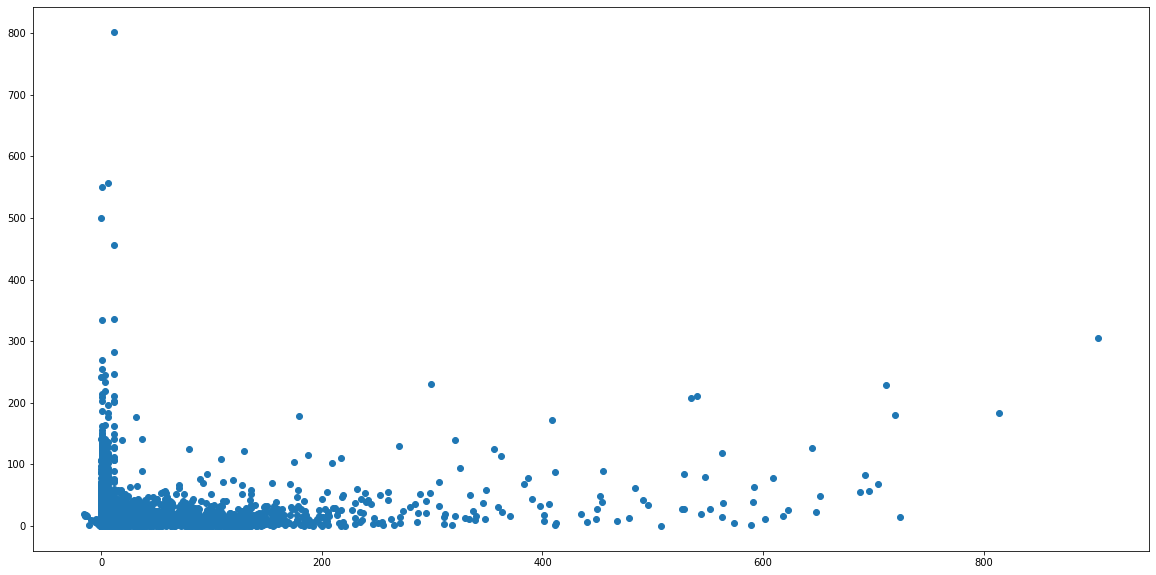

In [18]:
plt.scatter(x='predict',y='diff',data=sure_train)

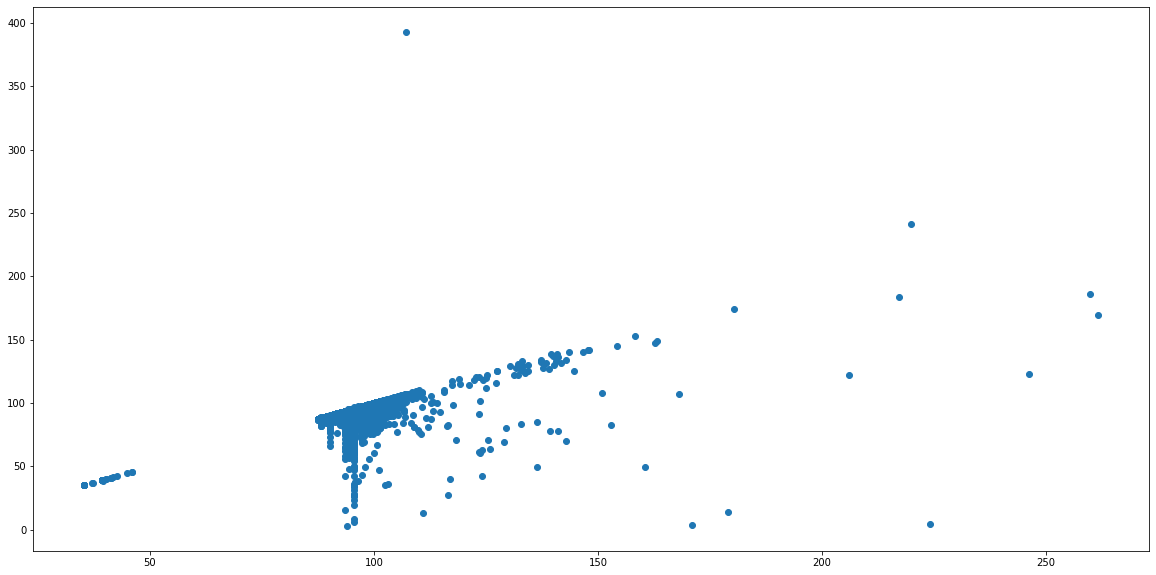

In [19]:
plt.scatter(x='predict',y='diff',data=sure_test, )

### 学習

In [20]:
'''
import lightgbm as lgb
lgb_dtrain = lgb.Dataset(train_X, train_y)
lgb_dvalid = lgb.Dataset(val_X, val_y)

param = {'objective': 'regression', 'metric': 'rmse', 
         'boosting_type': 'gbdt', 'feature_pre_filter': False, 
         'lambda_l1': 0.0009302714028467966, 'lambda_l2': 0.10623607699149125, 
         'num_leaves': 49, 'feature_fraction': 0.5, 'bagging_fraction': 0.6944916509216523, 
         'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 50}
lgb_evals_result = {}

lgb_model = lgb.train(param, 
                 lgb_dtrain,
                 valid_sets = [lgb_dtrain, lgb_dvalid],
                 valid_names = [ 'train', 'valid'],
                 evals_result = lgb_evals_result,
                 early_stopping_rounds=20)
'''

"\nimport lightgbm as lgb\nlgb_dtrain = lgb.Dataset(train_X, train_y)\nlgb_dvalid = lgb.Dataset(val_X, val_y)\n\nparam = {'objective': 'regression', 'metric': 'rmse', \n         'boosting_type': 'gbdt', 'feature_pre_filter': False, \n         'lambda_l1': 0.0009302714028467966, 'lambda_l2': 0.10623607699149125, \n         'num_leaves': 49, 'feature_fraction': 0.5, 'bagging_fraction': 0.6944916509216523, \n         'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 50}\nlgb_evals_result = {}\n\nlgb_model = lgb.train(param, \n                 lgb_dtrain,\n                 valid_sets = [lgb_dtrain, lgb_dvalid],\n                 valid_names = [ 'train', 'valid'],\n                 evals_result = lgb_evals_result,\n                 early_stopping_rounds=20)\n"

In [21]:
'''    sure_train = pd.concat([pd.Series(roop_model.predict(roop_train_X)), \
                            roop_train_y.reset_index(drop=True)], axis=1)
    sure_train.columns = ["predict", "item_cnt_month"]
    sure_train = pd.concat([roop_train_X.reset_index(drop=True), sure_train],axis=1)
    sure_train['diff'] = (sure_train['item_cnt_month'] - sure_train['predict']).abs()
    display(sure_train.sort_values('diff',ascending=False).head(5))
    print(sure_train.shape)

    sure_test = pd.concat([pd.Series(roop_pred_y), roop_test_y.reset_index(drop=True)], axis=1)
    sure_test.columns = ["predict", "item_cnt_month"]
    sure_test = pd.concat([roop_test_X.reset_index(drop=True), sure_test],axis=1)
    sure_test['diff'] = (sure_test['item_cnt_month'] - sure_test['predict']).abs()
    #sure_train = sure_train.reset_index(drop=True)
    #sure_train = sure_train[sure_train['diff'] > 100]
    display(sure_test.sort_values('diff',ascending=False).head(5))
    print(sure_test.shape)
'''

'    sure_train = pd.concat([pd.Series(roop_model.predict(roop_train_X)),                             roop_train_y.reset_index(drop=True)], axis=1)\n    sure_train.columns = ["predict", "item_cnt_month"]\n    sure_train = pd.concat([roop_train_X.reset_index(drop=True), sure_train],axis=1)\n    sure_train[\'diff\'] = (sure_train[\'item_cnt_month\'] - sure_train[\'predict\']).abs()\n    display(sure_train.sort_values(\'diff\',ascending=False).head(5))\n    print(sure_train.shape)\n\n    sure_test = pd.concat([pd.Series(roop_pred_y), roop_test_y.reset_index(drop=True)], axis=1)\n    sure_test.columns = ["predict", "item_cnt_month"]\n    sure_test = pd.concat([roop_test_X.reset_index(drop=True), sure_test],axis=1)\n    sure_test[\'diff\'] = (sure_test[\'item_cnt_month\'] - sure_test[\'predict\']).abs()\n    #sure_train = sure_train.reset_index(drop=True)\n    #sure_train = sure_train[sure_train[\'diff\'] > 100]\n    display(sure_test.sort_values(\'diff\',ascending=False).head(5))\n    prin

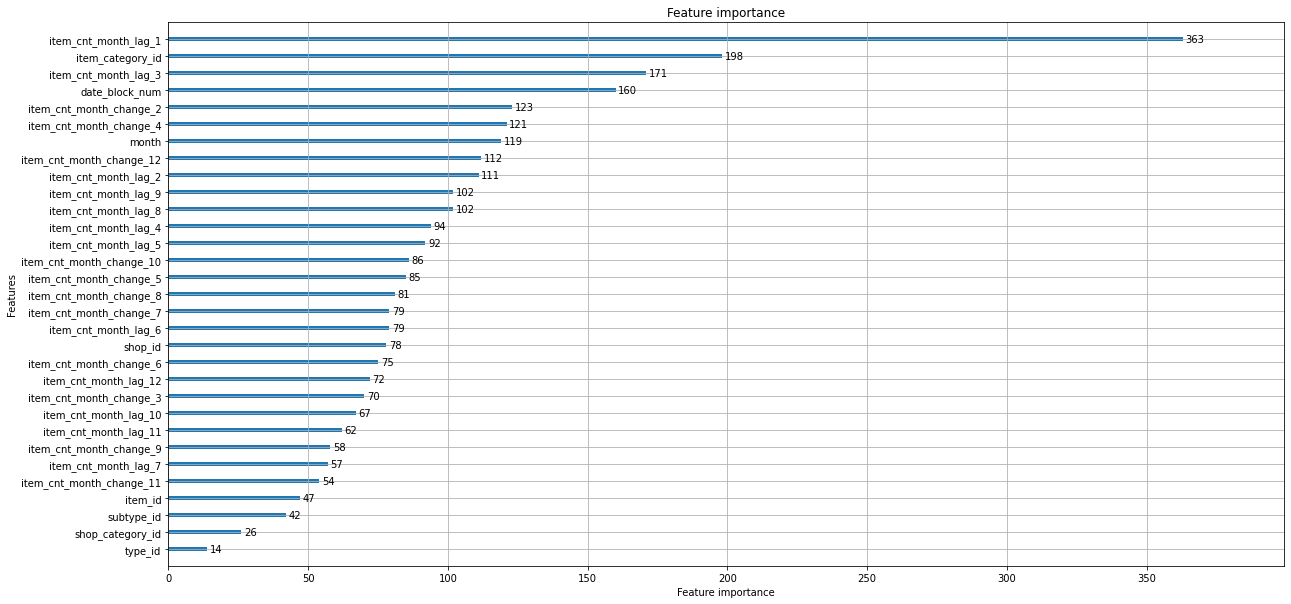

In [22]:
from lightgbm import plot_importance
lgb.plot_importance(roop_model)
plt.show()

In [23]:
ts = time.time()
plt.figure(figsize=(20,20))

sns.scatterplot(x = "predict", y = "diff", data=sure_test_df)

plt.plot(np.linspace(0, 800, 100), np.linspace(100, 100, 100), "red")
plt.plot(np.linspace(0, 800, 100), np.linspace(-100, -100, 100), "red")

plt.legend()
plt.show()
time.time()-ts

# ただし, diff = item_cnt_month - predict

NameError: name 'sure_test_df' is not defined

<Figure size 1440x1440 with 0 Axes>

### 提出

In [ ]:
test_y = model.predict(xgb.DMatrix(test_X)).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": test_y
})
# 提出の際、欠損値でエラーが出ないか確認
print(submission.isna().sum())

submission.to_csv('xgb_submission.csv', index=False)

### 結果の可視化  
#### 訓練データのRMSE

In [ ]:
# 訓練データのRMSE
train_pred_y = model.predict(xgb.DMatrix(train_X))

mse = mean_squared_error(train_y, train_pred_y)
rmse = np.sqrt(mse)
print(f"訓練データのRMSE:{rmse}\n")

plt.figure(figsize=(8,8))
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel("train_y")
plt.ylabel("train_pred_y")

plt.scatter(train_y, train_pred_y, alpha = 0.5, s=0.5)
plt.plot(np.linspace(0, 20, 100), np.linspace(0, 20, 100), "red")

plt.show()

#### 検証データのRMSE

In [ ]:
pred_y = model.predict(xgb.DMatrix(val_X))# .round()

mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
print(f"検証データのRMSE:{rmse}\n")

plt.figure(figsize=(8,8))
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel("val_y")
plt.ylabel("pred_y")

plt.scatter(val_y, pred_y, alpha = 0.5, s=0.5)
plt.plot(np.linspace(0, 20, 100), np.linspace(0, 20, 100), "red")

plt.show()

#### 学習曲線

In [ ]:
plt.plot(results_dict["train"]["rmse"], color = "red", label = "train")
plt.plot(results_dict["valid"]["rmse"], color = "blue", label = "valid")
plt.legend()
plt.show()

#### 重要度(分岐寄与数)

In [ ]:
xgb.plot_importance(model)
plt.show()

#### 重要度(寄与度)

In [ ]:
xgb.plot_importance(model, importance_type = "gain")
plt.show()

#### 決定木

In [ ]:
fig = plt.figure(figsize=(100,100))
ax = plt.subplot()
xgb.plot_tree(model, num_trees=2, ax=ax, rankdir='LR')
# fig.savefig("img.png")
plt.show()